In [1]:
## the data directory
datadir = '../Data/'


In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import partition_igraph
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import adjusted_rand_score as ARI


### American College Football Graph

This is a nice, small graph for illustrating anomaly detection methods.
The graph consists of 115 US college football teams (nodes) playing games (edges).

Teams are part of 12 conferences (the 'communities'):
*   0 = Atlantic Coast
*   1 = Big East
*   2 = Big Ten
*   3 = Big Twelve
*   4 = Conference USA
*   5 = Independents
*   6 = Mid-American
*   7 = Mountain West
*   8 = Pacific Ten
*   9 = Southeastern
*  10 = Sun Belt
*  11 = Western Athletic

14 teams out of 115 appear as "anomalies" as can be seen in Figure 5 of [REF], namely:
- 5 teams in #5 conference (Independent) play teams in other conferences (green triangles in plot below)
- 7 teams in #10 conference (Sun Belt) are broken in 2 clumps (pink triangles in plot below) 
- 2 teams from #11 conference play mainly with #10 conference (red triangles below)

[REF]: "Community structure in social and biological networks", M. Girvan and M. E. J. Newman
PNAS June 11, 2002 99 (12) 7821-7826; https://doi.org/10.1073/pnas.122653799



In [3]:
def sum_of_l2(g, ly):
    s = 0
    for e in g.es:
        if g.vs[e.source]['ecg'] == g.vs[e.target]['ecg']:
            s -= np.linalg.norm(np.array(ly[e.source])-np.array(ly[e.target]))
        else:
            s += np.linalg.norm(np.array(ly[e.source])-np.array(ly[e.target]))
    return s

-118.38136054599737


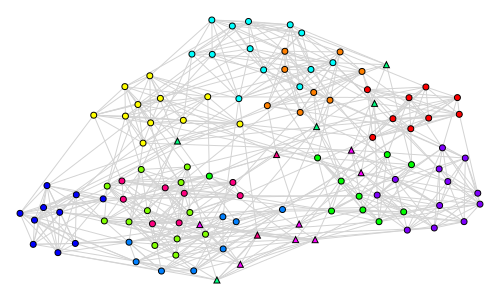

In [4]:
## read graph and communities
cfg = ig.Graph.Read_Ncol(datadir+'Football/football.edgelist',directed=False)
c = np.loadtxt(datadir+'Football/football.community',dtype='uint16',usecols=(0))
cfg.vs['community'] = [c[int(x['name'])] for x in cfg.vs]

## plot the College Football Graph
## show communities in dfferent colors
## show known anomalies as triangles
cfg.vs['shape'] = 'circle'
cfg.vs['anomaly'] = 0
pal = ig.RainbowPalette(n=max(cfg.vs['community'])+1) 
cfg.vs['color'] = [pal.get(int(i)) for i in cfg.vs['community']]
for v in cfg.vs:
    if v['community'] in [5,10] or v['name'] in ['28','58']:
        v['shape']='triangle'
        v['anomaly']=1
ecg = cfg.community_ecg(final='leiden')
cfg.vs['ecg'] = ecg.membership
ly = cfg.layout_fruchterman_reingold()
print(sum_of_l2(cfg,ly))
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), vertex_size=6, edge_color='lightgray')


In [5]:
## Clustering with refusals
## Score #1: 1 - average edge score
## Score #2: (total score over inter-community edges) / (total score over all edges)
def refuse(G, EC, method='overall'):
    G.es['W'] = EC.W
    G.vs['deg'] = G.degree()
    v = G.vs[0]
    if method=='overall':
        for v in G.vs:
            scr = 0
            for e in v.incident():
                scr += e['W']
            v['refuse_score'] = ((v['deg']-scr)/v['deg'])
    elif method=='community':
        G.vs['ecg'] = EC.membership
        for v in G.vs:
            my_comm = v['ecg']
            good = 0
            bad = 0
            for e in v.incident():
                if G.vs[e.source]['ecg'] == G.vs[e.target]['ecg']:
                    good += e['W']
                else:
                    bad += e['W']
            v['refuse_score'] = (bad/(bad+good))        

In [6]:
n = cfg.vcount()
refuse(cfg,ecg,method='overall')
L = []
for i in range(n):
    srt = list(np.argsort(cfg.vs['refuse_score']))[:n-i]
    if i>0:
        L.append([i, ARI(cfg.vs[srt]['ecg'],cfg.vs[srt]['community']),
            sum([cfg.vs[i]['anomaly'] for i in list(np.argsort(cfg.vs['refuse_score']))[-i:]])])
    else:
        L.append([i, ARI(cfg.vs[srt]['ecg'],cfg.vs[srt]['community']),0])
df = pd.DataFrame(L, columns=['refusals','ARI','outliers found'])

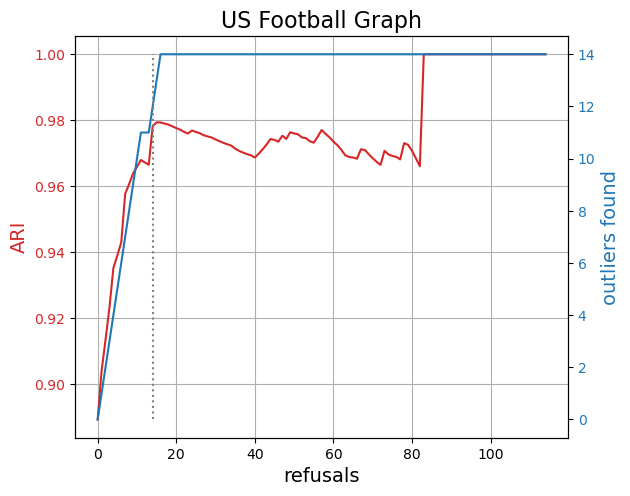

In [7]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('refusals', fontsize=14)
ax1.set_ylabel('ARI', color=color, fontsize=14)
ax1.plot(df['refusals'],df['ARI'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('outliers found', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(df['refusals'],df['outliers found'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('US Football Graph', fontsize=16)
plt.vlines(14,0,14,color='grey',linestyles='dotted')
plt.show()

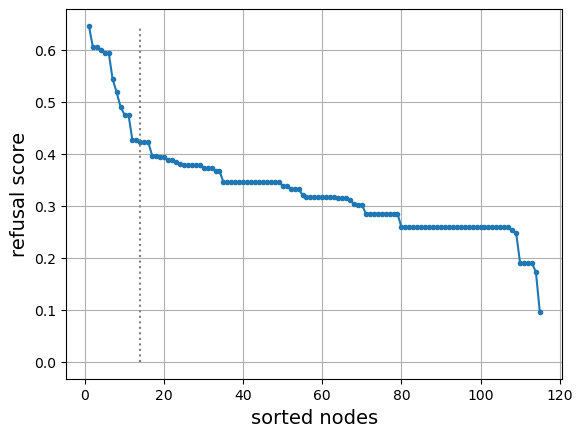

In [8]:
srt = list(np.sort(cfg.vs['refuse_score']))
srt.reverse()
plt.plot(np.arange(1,n+1),srt,'.-')
plt.grid()
plt.vlines(14,0,srt[0],color='grey',linestyles='dotted')
plt.ylabel('refusal score', fontsize=14)
plt.xlabel('sorted nodes', fontsize=14);

875.9781165606337


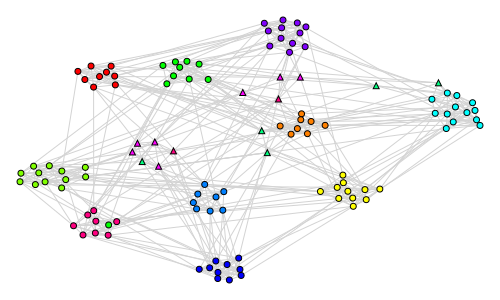

In [9]:
cfg.es['weight'] = ecg.W
cfg.vs['size'] = 6
for v in np.argsort(cfg.vs['refuse_score'])[-6:]:
    cfg.vs[v]['size'] = 6
ly = cfg.layout_fruchterman_reingold(weights='weight')
print(sum_of_l2(cfg,ly))
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), edge_color='lightgray')

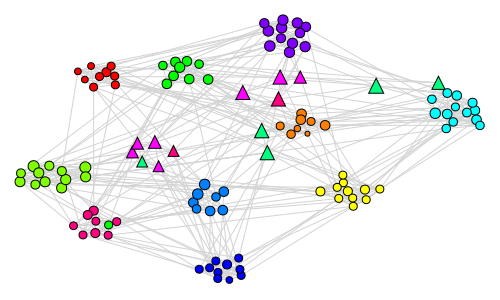

In [10]:
m = np.min(cfg.vs['refuse_score'])
M = np.max(cfg.vs['refuse_score'])

cfg.vs['size'] = 5+10*(cfg.vs['refuse_score'] - m)/(M-m)
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), edge_color='lightgray')

In [11]:
# p(a,b): prop of edges for a going to same community as b
# w(a,b) = (p(a,b)+p(b,a))/2

from collections import Counter

In [12]:
# dict for each node: communities of each neighbor
for i in range(cfg.vcount()):
    cfg.vs[i]['nei_com'] = Counter([cfg.vs[j]['ecg'] for j in cfg.neighbors(i)])
cfg.vs['deg'] = cfg.degree()

In [13]:
for e in cfg.es:
    u = cfg.vs[e.source]
    v = cfg.vs[e.target]
    e['bks'] = ((u['nei_com'][v['ecg']] / u['deg']) + (v['nei_com'][u['ecg']] / v['deg']))/2

428.50363166512847


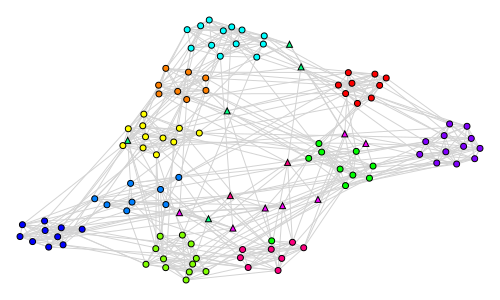

In [14]:
ly = cfg.layout_fruchterman_reingold(weights='bks')
print(sum_of_l2(cfg,ly))
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), edge_color='lightgray', vertex_size=6)


# ABCD+o tests

In [51]:
## read graph and communities (pick one from below)

g = ig.Graph.Read_Ncol(datadir+'ABCDo/Noise_30/edge.dat',directed=False)
c = np.loadtxt(datadir+'ABCDo/Noise_30/com.dat',dtype='uint16',usecols=(1))

#g = ig.Graph.Read_Ncol(datadir+'ABCDo/Noise_40/edge.dat',directed=False)
#c = np.loadtxt(datadir+'ABCDo/Noise_40/com.dat',dtype='uint16',usecols=(1))

#g = ig.Graph.Read_Ncol(datadir+'ABCDo/Noise_50/edge.dat',directed=False)
#c = np.loadtxt(datadir+'ABCDo/Noise_50/com.dat',dtype='uint16',usecols=(1))

g.vs['community'] = [c[int(x['name'])-1]-1 for x in g.vs]
g.vs['size'] = 5
g.es['color'] = 'grey'
cls = ['red','green','blue','gold','purple','black','brown','cyan','magenta']
g.vs['color'] = [cls[i] for i in g.vs['community']]


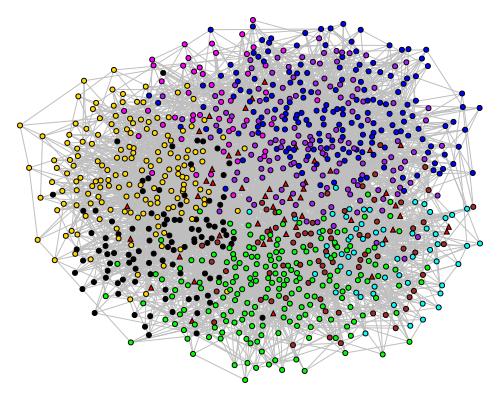

In [52]:
ly = g.layout_fruchterman_reingold()
g.vs['shape'] = 'circle'
g.vs['anomaly'] = 0
for v in g.vs:
    if v['community']==0:
        v['shape'] = 'triangle'
        v['anomaly'] = 1
ig.plot(g, layout=ly, bbox=(0,0,500,400))

11075.45222035464


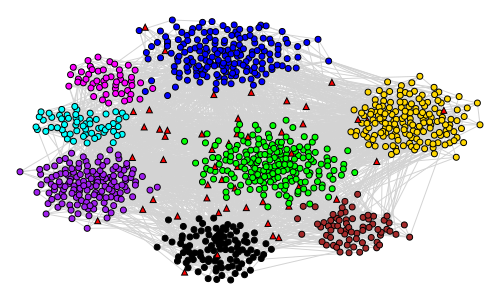

In [53]:
ecg = g.community_ecg(final='leiden')
g.es['weight'] = ecg.W
g.vs['size'] = 6
g.vs['ecg'] = ecg.membership
refuse(g,ecg,method='overall')
ly = g.layout_fruchterman_reingold(weights='weight')
print(sum_of_l2(g,ly))
ig.plot(g, layout=ly, bbox=(0,0,500,300), edge_color='lightgray')

In [54]:
n = g.vcount()
refuse(g,ecg,method='community')
L = []
for i in range(n):
    srt = list(np.argsort(g.vs['refuse_score']))[:n-i]
    if i>0:
        L.append([i, ARI(g.vs[srt]['ecg'],g.vs[srt]['community']),
            sum([g.vs[i]['anomaly'] for i in list(np.argsort(g.vs['refuse_score']))[-i:]])])
    else:
        L.append([i, ARI(g.vs[srt]['ecg'],g.vs[srt]['community']),0])
df = pd.DataFrame(L, columns=['refusals','ARI','outliers found'])

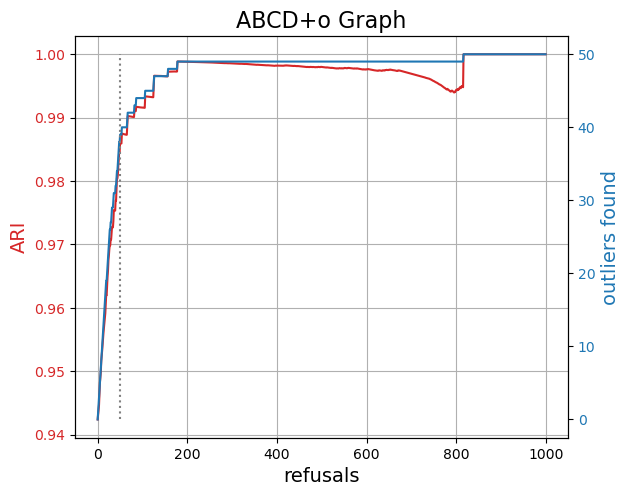

In [55]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('refusals', fontsize=14)
ax1.set_ylabel('ARI', color=color, fontsize=14)
ax1.plot(df['refusals'],df['ARI'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('outliers found', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(df['refusals'],df['outliers found'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('ABCD+o Graph', fontsize=16)
plt.vlines(50,0,50,color='grey',linestyles='dotted')
plt.show()

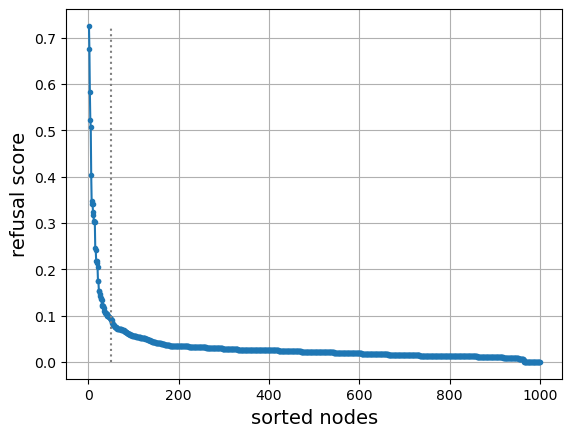

In [56]:
srt = list(np.sort(g.vs['refuse_score']))
srt.reverse()
plt.plot(np.arange(1,n+1),srt,'.-')
plt.grid()
plt.vlines(50,0,srt[0],color='grey',linestyles='dotted')
plt.ylabel('refusal score', fontsize=14)
plt.xlabel('sorted nodes', fontsize=14);